<mark>pandas
- loc函数主要通过 行标签 索引行数据  
- iloc函数主要通过 行号 索引行数据

In [4]:
import pandas as pd
import numpy as np
df = pd.DataFrame({'城市':['北京','广州', '天津', '上海', '杭州', '成都', '澳门', '南京'], 
 
                   '收入':[10000, 10000, 5000, 5002, 40000, 50000, 8000, 5000],
 
                    '年龄':[50, 43, 34, 40, 25, 25, 45, 32]})
df.set_index([["一","二","三","四","五","六","七","八"]],inplace=True)
print(df.loc[["一","二"],"城市":"收入"])
print("\n",df.iloc[:2,:3])

   城市     收入
一  北京  10000
二  广州  10000

    城市     收入  年龄
一  北京  10000  50
二  广州  10000  43


# HOUSE PRICE

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data.shape, test_data.shape #test没有label

((1460, 81), (1459, 80))

In [4]:
print("\t[train data]\n",train_data.iloc[0:4,[0,1,2,3,4,-1]])
print("\n\t[test data]\n",test_data.iloc[0:2,:5])

	[train data]
    Id  MSSubClass MSZoning  LotFrontage  LotArea  SalePrice
0   1          60       RL         65.0     8450     208500
1   2          20       RL         80.0     9600     181500
2   3          60       RL         68.0    11250     223500
3   4          70       RL         60.0     9550     140000

	[test data]
      Id  MSSubClass MSZoning  LotFrontage  LotArea
0  1461          20       RH         80.0    11622
1  1462          20       RL         81.0    14267


Train第一个特征是ID，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以不使用它来训练。<mark>去掉Id</mark>

我们将所有的训练数据和测试数据的79个特征按样本连结。

In [5]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:-1]))
all_features.shape

(2919, 79)

# 数据预处理

我们对连续数值的特征做标准化（standardization）：

设该特征在<mark>整个数据集</mark>上的均值为 μ ，标准差为 σ 。

为了将所有特征放在一个共同的尺度上，将特征重新缩放到零均值和单位方差来标准化数据；即特征的每个值先减去 μ 再除以 σ 得到标准化后的每个特征值。

-> 标准化数据有两个原因
- 方便优化
- 因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大


最后，对于缺失的特征值，我们将其替换成该特征的均值。

In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print(numeric_features[:5]) #存着value为离散数值的列的index名字
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
# 在标准化数据之后，每个特征的均值变为0，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'], dtype='object')


接下来将离散数值转成指示特征。

举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

In [7]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape #(2919, 331);将特征数从79增加到了331

(2919, 331)

最后，通过values属性得到NumPy格式的数据，并转成NDArray方便后面的训练。

In [8]:
n_train = train_data.shape[0]

train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float32)
#log_labels = np.log1p(train_data.SalePrice.values)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),dtype=torch.float32)

# 训练模型

In [9]:
loss = nn.MSELoss()   #平方损失函数

in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,128),nn.ReLU(),nn.Linear(128,1))
    return net

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

对于房价，就像股票价格一样，我们关心的是相对数量，而不是绝对数量。因此，我们更关心<mark>相对误差 y−y^/y </mark>，而不是绝对误差 y−y^ 。

- 例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，我们的预测偏差了10万美元，在那里一栋典型的房子的价值是12.5万美元，那么我们可能做得很糟糕。
- 另一方面，如果我们在加州豪宅区的预测出现了这个数字的偏差，这可能是一个惊人的准确预测（在那里，房价均值超过400万美元）。

-> <mark>价格预测的对数</mark>来衡量差异。|logy−logy^|≤δ 转换为 e−δ≤ y^/y ≤eδ。

In [10]:
def log_mse(net,features,labels):
    # 为了在取对数时进一步稳定该值，将pred_y小于1的值设置为1
    clipped_preds = torch.clamp(net(features),1,float('inf'))
    #将输入input张量每个元素的夹紧到区间 [min,max],并返回结果到一个新张量。小于min取min，大于max取max，其余不变。
    log_mse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return log_mse.item()
    #Returns the value of this tensor as a standard Python number. This only works for tensors with one element. 
    #For other cases, see tolist().

训练函数将借助Adam优化器，其对初始学习率不那么敏感。

In [11]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size ):
    train_ls, test_ls = [],[]
    train_iter = d2l.load_array((train_features,train_labels),batch_size)
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate, weight_decay = weight_decay)
    
    for epoch in range(num_epochs): #range(start=0, stop, step=1)
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            #l = loss(torch.log(net(X)),torch.log(y)) #nan
            #l = loss(torch.log(net(X).clamp(1,float('inf'))),torch.log(y)) #平均训练log mse: 3.215072, 平均验证log mse: 3.214717
            l.backward()
            optimizer.step()
        train_ls.append(log_mse(net,train_features,train_labels))
        #The append() method adds an item to the end of the list.
        if test_labels is not None:
            test_ls.append(log_mse(net,test_features,test_labels))
    return train_ls,test_ls
        

# K-折交叉验证

In [12]:
def get_k_fold_data(k, i, X, y):
    '''返回第i折所对应的 train_Set和valid_Set'''
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [13]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net() #每折都训练一个新的net，为了看出该次超参数和模型结构是不是足够好。
        net.apply(init_weights);
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log mse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [14]:
train_features.shape, train_labels.shape

(torch.Size([1460, 331]), torch.Size([1460, 1]))

# 模型选择

fold 1, train log mse 0.114468, valid log rmse 0.123389
fold 2, train log mse 0.114201, valid log rmse 0.141385
fold 3, train log mse 0.113138, valid log rmse 0.133485
fold 4, train log mse 0.119496, valid log rmse 0.113021
fold 5, train log mse 0.106762, valid log rmse 0.152947
5-折验证: 平均训练log mse: 0.113613, 平均验证log mse: 0.132846


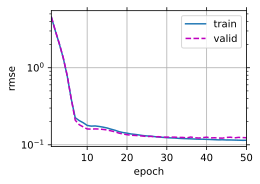

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5,  50, 0.04, 90, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log mse: {float(train_l):f}, '
      f'平均验证log mse: {float(valid_l):f}')

# 问题：
- SGD net(features)=nan

- 真实数据通常混合了不同的数据类型，需要进行预处理。

- 你能通过直接最小化价格的对数来改进你的模型吗？如果你试图预测价格的对数而不是价格，会发生什么？

- 用平均值替换缺失值总是好主意吗？提示：你能构造一个不随机丢失值的情况吗？

- 通过 K 折交叉验证调整超参数，从而提高Kaggle的得分。

- 通过改进模型（例如，层、权重衰减和dropout）来提高分数。

- 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？

In [16]:
test_features.shape,test_data.shape

(torch.Size([1459, 331]), (1459, 80))

# Kaggle预测

train log rmse 0.111429


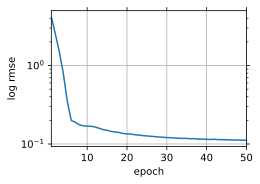

In [17]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    
    '''#TEST
    Test_preds = net(train_features).detach().numpy()
    Test_preds = np.expm1(Test_preds)
    Test_real =  np.expm1(train_labels.detach().numpy())
    #Test_mse = nn.MSELoss(Test_preds,Test_real)
    Test_mse = np.square(((Test_preds - Test_real)**2).mean())
    print(Test_mse)
    print(Test_preds[:4].reshape(1,-1)) '''
    
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    #preds = np.expm1(preds)
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

真实trian_labels:[ 208500, 181500, 223500,140000]